In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

### 🧰 Library Imports

This cell imports all necessary libraries for:
- **Data processing**: NumPy, pandas
- **Visualization**: Seaborn, Matplotlib
- **Machine Learning & Clustering**: Scikit-learn, UMAP, HDBSCAN
- **Deep Learning**: TensorFlow (for modeling)
- **Suppressing warnings** for cleaner output


### 🔧 Add Custom Module Path

Include the GitHub repo’s `/src` directory in the Python path so we can import custom modules like:
- `data_loader`
- `data_cleaner`
- `features` (consumption, temporal, weather, etc.)


In [2]:
pip install optuna-integration[xgboost]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.5/98.5 kB 4.9 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [3]:
import sys
sys.path.append("/kaggle/input/utility-smart-meter/src")

In [4]:
from data.data_loader import load_all_raw_data  # or any specific function/class you need
# Import the main cleaning function
from data.data_cleaner import clean_and_merge_all_data
# Import the comprehensive feature builder
from features.feature_pipeline import create_comprehensive_features

## 📁 Dataset Overview & Loading

This project uses the **London Smart Meter Dataset**, provided by UK Power Networks through the **London Data Store**. The dataset includes:

- Half-hourly electricity readings for over 5,000 households
- Data range: **November 2011 to February 2014**
- File structure: Split across multiple CSV blocks (`block_0.csv`, `block_1.csv`, etc.)
- Metadata: Includes household tariff types, ACORN demographic segmentation (if available)

We’ll load and combine all half-hourly blocks into one master DataFrame for preprocessing.


In [5]:
# Set the base path where all your data files and folders are located
data_path = "/kaggle/input/smart-meters-in-london"

# Call the function to load all raw datasets: consumption, household, weather, and holiday data
raw_data = load_all_raw_data(data_path)

# Extract each dataset from the returned dictionary for easier access
df_consumption = raw_data["consumption"]  # Half-hourly electricity consumption records
df_household = raw_data["household"]      # Household metadata (e.g., tariff, ACORN group)
df_weather = raw_data["weather"]          # Daily weather data
df_holiday = raw_data["holiday"]          # UK bank holiday dates

# Display the first few rows of the consumption data to confirm successful loading
df_consumption.head()

🚀 LOADING ALL RAW DATA
📂 Found 112 consumption files
✅ Loaded 3,469,352 consumption records
📂 Loading household data...
✅ Loaded 5,566 households
📂 Loading weather data...
✅ Loaded 882 weather records
📂 Loading holiday data...
✅ Loaded 25 holiday records
🎉 ALL RAW DATA LOADED


,LCLid,day,hh_0,hh_1,hh_2,hh_3,hh_4,hh_5,hh_6,hh_7,...,hh_38,hh_39,hh_40,hh_41,hh_42,hh_43,hh_44,hh_45,hh_46,hh_47
0,MAC000047,2011-12-09,0.114,0.074,0.107,0.098,0.090,0.106,0.077,0.115,...,0.097,0.134,0.295,0.063,0.072,0.040,0.074,0.051,0.065,0.068
1,MAC000047,2011-12-10,0.035,0.082,0.050,0.064,0.059,0.048,0.082,0.044,...,0.120,0.115,0.106,0.135,0.077,0.104,0.096,0.076,0.106,0.076
2,MAC000047,2011-12-11,0.103,0.085,0.083,0.113,0.072,0.096,0.098,0.084,...,0.191,0.163,0.203,0.182,0.168,0.145,0.074,0.114,0.078,0.096
3,MAC000047,2011-12-12,0.107,0.072,0.109,0.088,0.099,0.098,0.075,0.120,...,0.160,0.195,0.156,0.105,0.125,0.076,0.111,0.074,0.098,0.104
4,MAC000047,2011-12-13,0.073,0.108,0.084,0.101,0.095,0.078,0.118,0.080,...,0.181,0.130,0.146,0.116,0.113,0.110,0.082,0.120,0.079,0.101


## 🧼 Initial Preprocessing

In this step, we prepare the data for analysis and clustering by:

- Removing rows with missing or zero consumption
- Extracting time components: hour, weekday, month
- Assigning seasons (Winter, Spring, etc.)
- Optionally: joining household demographics (ACORN categories)
- Optionally: joining external weather data

This enriched data structure will support deeper behavioral clustering and temporal analysis.


In [6]:
# Clean and merge all raw data
df_final = clean_and_merge_all_data(raw_data)

# View the final cleaned and enriched dataset
df_final.head()

🚀 CLEANING AND MERGING ALL DATA
🧹 Cleaning consumption data...
   ✅ Removed 0 rows with >20.0% missing
   ✅ Kept 5,556 households with ≥30 days
   🔧 Interpolating missing values...
✅ Consumption data cleaned: (3469317, 50)
🏠 Preparing household data...
✅ Household data prepared: (5566, 4)
🌤️ Preparing weather data...
✅ Weather data prepared: (882, 6)
🎉 Preparing holiday data...
✅ Holiday data prepared: (25, 3)
🔗 Merging all datasets...
   ✅ After household merge: (3469317, 53)
   ✅ After weather merge: (3475901, 58)
   ✅ After holiday merge: (3475901, 59)
✅ All data merged successfully
📅 Adding basic temporal features...
✅ Temporal features added
🎉 FINAL CLEANED DATASET: (3475901, 61)


,LCLid,day,hh_0,hh_1,hh_2,hh_3,hh_4,hh_5,hh_6,hh_7,...,Acorn_grouped,stdorToU,temperatureMax,temperatureMin,humidity,windSpeed,cloudCover,holiday_category,month,season
0,MAC000047,2011-12-09,0.114,0.074,0.107,0.098,0.090,0.106,0.077,0.115,...,Adversity,Std,7.68,2.03,0.71,5.65,0.15,Regular Day,12,Winter
1,MAC000047,2011-12-10,0.035,0.082,0.050,0.064,0.059,0.048,0.082,0.044,...,Adversity,Std,6.08,-0.13,0.81,3.08,0.17,Regular Day,12,Winter
2,MAC000047,2011-12-11,0.103,0.085,0.083,0.113,0.072,0.096,0.098,0.084,...,Adversity,Std,8.59,2.48,0.88,3.94,0.56,Regular Day,12,Winter
3,MAC000047,2011-12-12,0.107,0.072,0.109,0.088,0.099,0.098,0.075,0.120,...,Adversity,Std,9.82,3.09,0.84,5.02,0.38,Regular Day,12,Winter
4,MAC000047,2011-12-13,0.073,0.108,0.084,0.101,0.095,0.078,0.118,0.080,...,Adversity,Std,12.08,4.54,0.75,7.44,0.42,Regular Day,12,Winter


## 🧪 Feature Engineering

In this section, we generate time-domain and contextual features to describe each household's energy behavior on a daily basis. These features will serve as inputs to our clustering algorithms.

### 🔢 Key Features:

- **Temporal**: day, month, season, weekday/weekend, trend
- **Consumption**: total/peak/mean kWh, time-of-day splits
- **Weather**: temperature, humidity, wind, cloud, seasonal interaction
- **ACORN-based**: group-level usage and variability
- **Time Series**: lags, rolling windows, volatility
- **Interactions**: weather x temporal, holiday x usage

📊 Final dataset now has 147 columns (features) ready for modeling.


In [7]:
# Run the full feature pipeline
df_features = create_comprehensive_features(df_final)

# Check the final DataFrame
df_features.head()

🚀 CREATING COMPREHENSIVE FEATURES FOR FORECASTING
🚀 Creating All Temporal Features
📅 Creating basic temporal features...
   ✅ Created basic temporal features
🌀 Creating seasonal features...
   ✅ Created seasonal features
🎉 Creating holiday features...
   ✅ Created holiday features
⚡ Creating peak period features...
   ⚠️ peak_hour column not found
📈 Creating time trend features...
   ✅ Created time trend features
✅ All temporal features created
⚡ Creating consumption features...
   ✅ Created consumption features
📊 Creating consumption patterns...
   ✅ Created consumption patterns
🚀 Creating All Weather Features
🌡️ Creating temperature features...
   ✅ Created temperature features
🌦️ Creating weather condition features...
   ✅ Created weather condition features from ['humidity', 'windSpeed', 'cloudCover']
🌡️ Creating temperature impact features...
   ✅ Created temperature impact features
🌨️ Creating seasonal weather features...
   ✅ Created seasonal weather features
✅ All weather featur

,LCLid,day,hh_0,hh_1,hh_2,hh_3,hh_4,hh_5,hh_6,hh_7,...,roll7_total_std,roll14_total_mean,roll14_total_std,delta1_total,pct_change1_total,weekly_change_total,weekend_heating,weekday_heating,summer_cooling,holiday_consumption_boost
0,MAC000002,2012-10-13,0.263,0.269,0.275,0.256,0.211,0.136,0.161,0.119,...,NaN,11.087000,NaN,NaN,NaN,NaN,7.435,0.000,0.0,0.0
1,MAC000002,2012-10-14,0.262,0.166,0.226,0.088,0.126,0.082,0.123,0.083,...,1.510380,12.155000,1.510380,2.136,0.192658,NaN,6.440,0.000,0.0,0.0
2,MAC000002,2012-10-15,0.192,0.097,0.141,0.083,0.132,0.070,0.130,0.074,...,1.530172,11.522333,1.530172,-2.966,-0.224306,NaN,0.000,3.100,0.0,0.0
3,MAC000002,2012-10-16,0.237,0.237,0.193,0.118,0.098,0.107,0.094,0.109,...,1.526268,11.084000,1.526268,-0.488,-0.047577,NaN,0.000,2.300,0.0,0.0
4,MAC000002,2012-10-17,0.157,0.211,0.155,0.169,0.101,0.117,0.084,0.118,...,1.324780,11.044200,1.324780,1.116,0.114239,NaN,0.000,0.905,0.0,0.0


## 🔍 Stage 0: Predictive Modeling & Driver Analysis

This stage helps uncover the most influential drivers of electricity consumption using a predictive modeling framework.

### 🎯 Objective

- Identify key variables (calendar, weather, socio-economic, behavioral patterns, lags) that explain variance in energy use.
- Quantify the marginal impact of each feature using SHAP values from an interpretable XGBoost model.

In [10]:
from evaluation.feature_analysis import generate_consumption_driver_report
from visualization.feature_plots import create_driver_analysis_dashboard
from models.predictive_model import prepare_driver_analysis_data, tune_hyperparameters, train_xgboost_model, calculate_shap_values
from features.feature_pipeline import create_comprehensive_features, prepare_forecasting_data

In [13]:
# Prepare data
train_df, val_df, test_df, feature_cols, target_col, feature_groups = prepare_driver_analysis_data(
    df=df_features,
    target_col="total_kwh",
    test_days=90,
    val_days=45
)

# Tune hyperparameters
best_params = tune_hyperparameters(
    train_df=train_df,
    val_df=val_df,
    feature_cols=feature_cols,
    target_col=target_col,
    n_trials=5,  # Adjust based on your time constraints
    use_gpu=True
)

# Train the model with best parameters
model, val_metrics, test_metrics = train_xgboost_model(
    train_df=train_df,
    val_df=val_df,
    test_df=test_df,
    feature_cols=feature_cols,
    target_col=target_col,
    params=best_params,
    use_gpu=True
)

# Calculate SHAP values
shap_results = calculate_shap_values(
    model_dict={'model': model},
    data_dict={'X_test': test_df[feature_cols]},
    sample_size=1000
)

# Prepare stage0 results
stage0_results = {
    'data': {
        'X_train': train_df[feature_cols],
        'X_test': test_df[feature_cols],
        'y_train': train_df[target_col],
        'y_test': test_df[target_col],
        'feature_cols': feature_cols,
        'feature_groups': feature_groups
    },
    'model': {
        'model': model
    },
    'shap': shap_results
}

📊 PREPARING DATA FOR CONSUMPTION DRIVER ANALYSIS
📋 Selected 88 features for modeling
🚫 Excluded 48 target-related features to prevent data leakage
🎯 Target variable: total_kwh

📅 Chronological Split:
   Training: 2011-11-24 00:00:00 to 2013-10-15 00:00:00 (2,792,631 samples)
   Validation: 2013-10-16 00:00:00 to 2013-11-29 00:00:00 (231,370 samples)
   Test: 2013-11-30 00:00:00 to 2014-02-27 00:00:00 (451,900 samples)

📋 FEATURE GROUP SUMMARY (LEAKAGE-FREE):
   half_hourly         : 48 features
      Sample: ['hh_0', 'hh_1', 'hh_2']
   temporal            :  8 features
   weather             : 17 features
   socio_economic      :  2 features
   external            :  1 features
   other               : 13 features
🎯 Tuning XGBoost Hyperparameters
🔄 Encoding 4 categorical variables...


[I 2025-05-31 05:11:28,336] A new study created in memory with name: no-name-a2e7f043-69b3-4f67-9141-b34fe30ddc49


  0%|          | 0/5 [00:00<?, ?it/s]

[I 2025-05-31 05:12:11,693] Trial 0 finished with value: 0.824287130779127 and parameters: {'max_depth': 5, 'min_child_weight': 10, 'gamma': 3.6599697090570253, 'learning_rate': 0.07661100707771368, 'n_estimators': 396, 'subsample': 0.662397808134481, 'colsample_bytree': 0.6232334448672797, 'reg_alpha': 0.08499808989182997, 'reg_lambda': 0.0006440507553993703}. Best is trial 0 with value: 0.824287130779127.
[I 2025-05-31 05:13:26,467] Trial 1 finished with value: 0.8251948536806608 and parameters: {'max_depth': 8, 'min_child_weight': 1, 'gamma': 4.8495492608099715, 'learning_rate': 0.16967533607196555, 'n_estimators': 503, 'subsample': 0.6727299868828402, 'colsample_bytree': 0.6733618039413735, 'reg_alpha': 2.716051144654844e-06, 'reg_lambda': 0.00015777981883364995}. Best is trial 0 with value: 0.824287130779127.
[I 2025-05-31 05:14:43,587] Trial 2 finished with value: 0.8228615733541488 and parameters: {'max_depth': 6, 'min_child_weight': 3, 'gamma': 3.0592644736118975, 'learning_rat

In [14]:
analysis_report = generate_consumption_driver_report(stage0_results)

📋 GENERATING COMPREHENSIVE CONSUMPTION DRIVER REPORT

=============== PERFORMANCE EVALUATION ===============
📈 EVALUATING MODEL PERFORMANCE
🔄 Encoding 4 categorical variables...
📊 PERFORMANCE SUMMARY:
   Variance Explained: 99.2%
   Test R²: 0.9925
   Test MAE: 0.3969 kWh
   Test RMSE: 0.8941 kWh
   Test MAPE: inf%
   Relative Error: 3.4%

=============== GLOBAL DRIVER RANKING ===============
🏆 RANKING TOP 15 CONSUMPTION DRIVERS
📊 TOP 15 CONSUMPTION DRIVERS:
--------------------------------------------------
    1. hh_42                     | SHAP: 0.4056 | 3.9%
    2. hh_41                     | SHAP: 0.3899 | 3.7%
    3. hh_43                     | SHAP: 0.3716 | 3.5%
    4. hh_40                     | SHAP: 0.3401 | 3.2%
    5. hh_44                     | SHAP: 0.3260 | 3.1%
    6. hh_38                     | SHAP: 0.3127 | 3.0%
    7. hh_45                     | SHAP: 0.2951 | 2.8%
    8. hh_36                     | SHAP: 0.2903 | 2.8%
    9. hh_39                     | SHAP: 0.276

🎨 CREATING COMPREHENSIVE CONSUMPTION DRIVER DASHBOARD
📊 Creating top drivers visualization...
📊 Creating top 15 drivers visualization...
✅ Plot saved to: plots//top_drivers.png
📊 Creating feature group importance...
📊 Creating feature group importance visualization...
✅ Plot saved to: plots//group_importance.png
📊 Creating household waterfall plots...
📊 Creating local household SHAP waterfall plots...
✅ Plot saved to: plots//household_waterfalls.png

🎉 DASHBOARD CREATION COMPLETED!
✅ 3 visualizations created
✅ Plots saved to: plots/


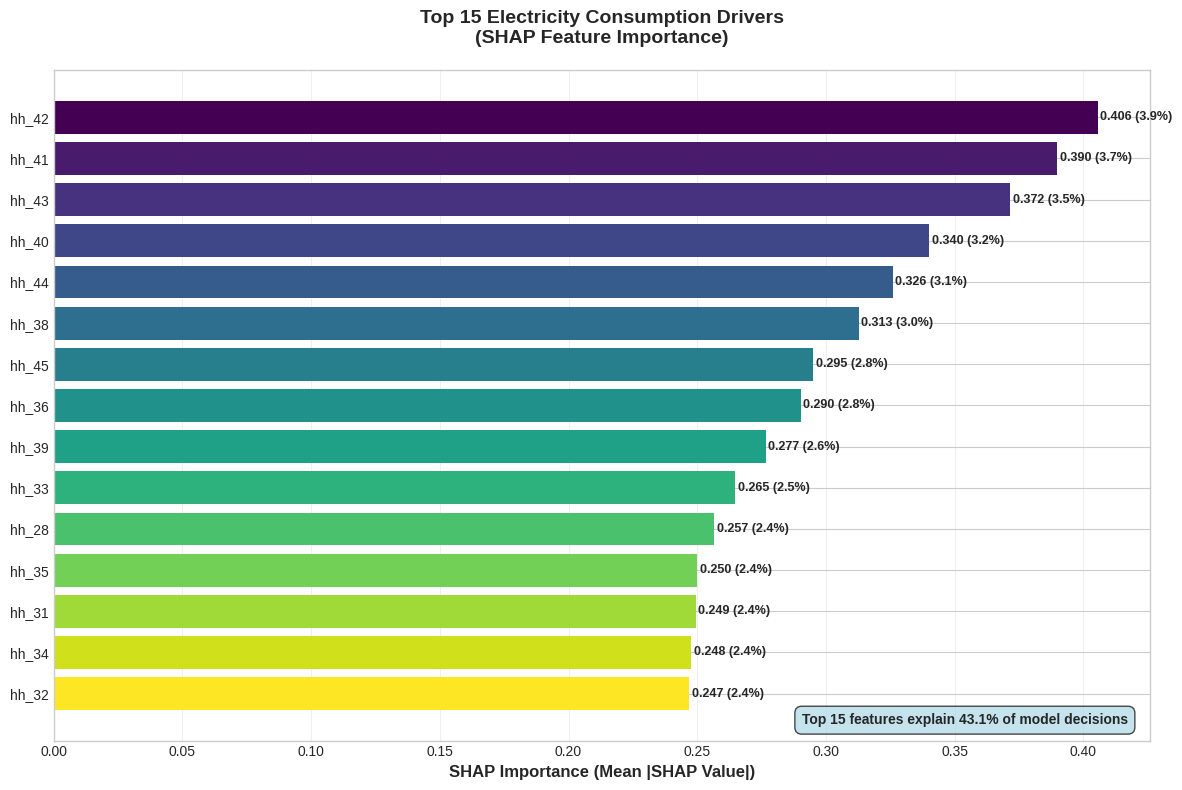

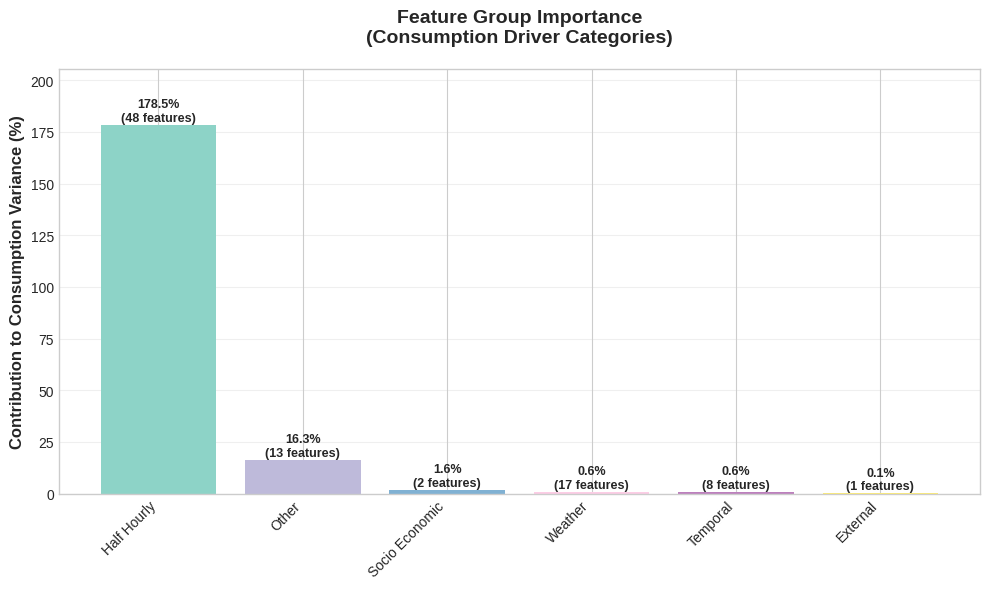

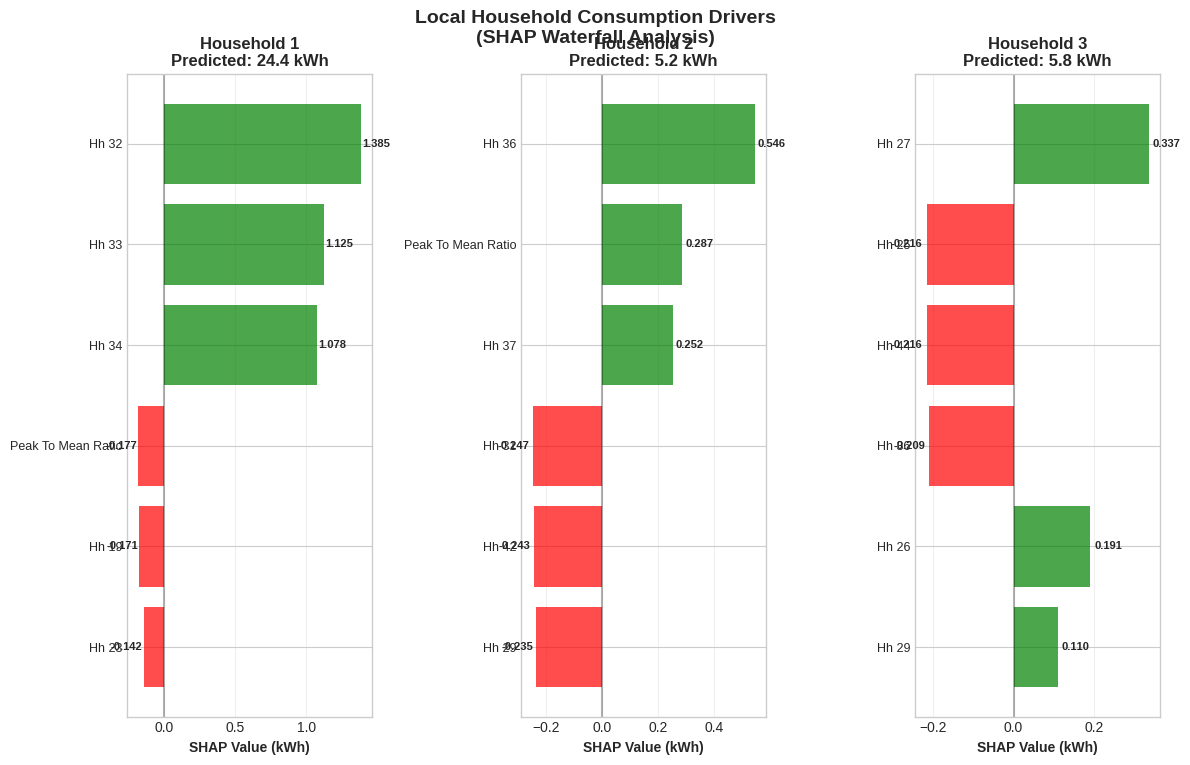

In [16]:
# 3. Create visualization dashboard
figures = create_driver_analysis_dashboard(analysis_report)

# 🔑 Key Takeaways: Electricity Consumption Driver Analysis

## ⚙️ Model Performance
- **Explains 99.25% of variance** (R² = 0.9925)
- **Test RMSE**: 0.894 kWh | **Validation RMSE**: 0.754 kWh
- **Minimal overfitting**: Consistent performance across train, validation, and test
- **No data leakage**: 48 target-related features excluded

## 🕘 Dominant Consumption Drivers
- **Top 5 features** are half-hourly usage between **8:00–10:30 PM**
  - `hh_42`, `hh_41`, `hh_43`, `hh_40`, `hh_44`
- **Behavioral timing explains 43.1%** of model decisions (top 15 features)
- These hours match peak household activity: cooking, entertainment, HVAC

## 📊 Feature Group Importance
- **Half-hourly features**: 178.5% of total SHAP importance (48 features)
- All other groups contribute **< 20%** combined:
  - Other: 16.3%
  - Socio-economic: 1.6%
  - Weather: 0.6%
  - Temporal: 0.6%
  - External: 0.1%

## 🏠 Household-Level Patterns
- **High-usage homes**: Strong, consistent evening peaks
- **Low/moderate users**: More varied patterns (some morning or distributed usage)
- Individual SHAP plots show usage concentration is a key differentiator

## ⚡ Business Implications
- **Focus demand response** and engagement on 8:00–10:30 PM
- **Time-of-use pricing** should reflect evening peak rates
- **Grid planning** should prioritize capacity and storage for late evening demand
- **Customer segmentation** possible based on usage patterns (evening vs. spread)
